# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from lungpetctdx_dataset import LungPetCtDxDataset_TumorPresence
from utils.wandb import start_wandb_run, wandb_watch, wandb_log
from eval.reconstruction_viusalization import compare_images


cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

'pynvml module not found, please install pynvml'

# Defining datasets (train/validation) 

In [10]:
IMAGE_RESOLUTION = 128

In [11]:
from lungpetctdx_dataset import LungPetCtDxDataset_TumorPresence
from ct_dataset import NormalizationMethods
postprocess = transforms.Compose([
    transforms.Grayscale()
])
ds = LungPetCtDxDataset_TumorPresence(post_normalize_transform=postprocess,
    normalize=NormalizationMethods.SINGLE_IMAGE, cache=True)

trainSet, valSet = ds.subject_split(0.2)#random_split(ds, [0.8, 0.2])
dataloaders = {
    "val": torch.utils.data.DataLoader(valSet, batch_size=128, shuffle=True, num_workers=8),
    "train": torch.utils.data.DataLoader(trainSet, batch_size=128, shuffle=True, num_workers=8),
}
num_classes = len(ds.class_names)
dataset_sizes = {"train": len(trainSet),"val": len(valSet)}

In [12]:
# model = torch.load("test")

# Defining model 

In [13]:
from capsule_net import CapsNet
from capsnet_config import Config

config = Config(
    cnn_in_channels=1,
    input_width=IMAGE_RESOLUTION,
    input_height=IMAGE_RESOLUTION,
    dc_in_channels=392,
    reconstruction_loss_factor=0.04,
    dc_num_capsules=num_classes,
    out_capsule_size=16,
    # Num labelled 0 tensor(5682)
    # Num labelled 1 tensor(47677)
    class_weights=torch.tensor([1., 5682/47677.]).to(device)
)

model = CapsNet(config)

start_wandb_run(config)

wandb_watch(model)
model.to(device)

CapsNet(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

# Setup training

In [14]:
from tqdm.notebook import tqdm
from utils.mask import mask_image

import numpy as np
from train import plot_train_losses, train_model, predicted_indices_from_outputs

# Define training parameters

In [15]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Run training

Epoch 1/1
----------
train Loss: 0.3751 Acc: 0.59983], train acc: 0.750000, batch loss: 10.883308, running reconstr. loss: 7.867581, running class. loss: 4.136026
val Loss: 0.3588 Acc: 0.5757668], train acc: 0.593750, batch loss: 11.909237, running reconstr. loss: 7.481174, running class. loss: 4.000456

Training complete in 48m 3s
Best val Acc: 0.575704


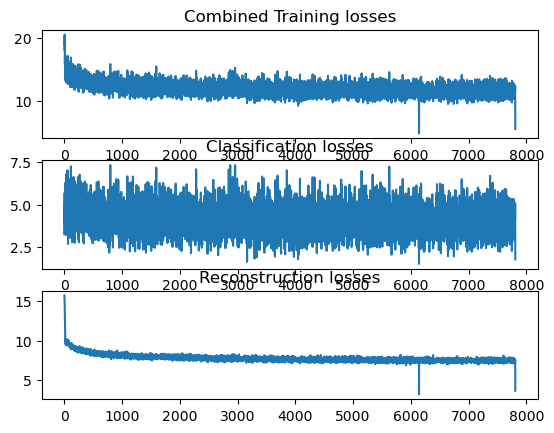

In [16]:
from train import train_model


(
    model,
    best_acc,
    best_loss,
    train_losses,
    best_acc_y_true,
    best_acc_y_pred,
) = train_model(
    model, exp_lr_scheduler, dataloaders["train"], dataloaders["val"], num_epochs=1
)

plot_train_losses(train_losses)

In [17]:
torch.save(model, "test.torch")

# Evaluation

Num labelled 0 tensor(5682)
Num labelled 1 tensor(47677)


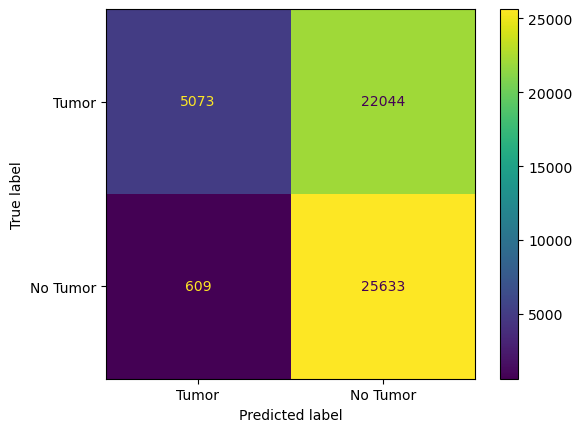

F1-score: 0.49829065640667375


In [18]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

num_labelled_1 = 0
num_labelled_0 = 0
y_true = np.array([])
y_pred = np.array([])
with torch.no_grad():
    for i, (inputs, classes, bboxes) in enumerate(dataloaders['val']):
        x = np.unique(classes, axis=0)
        if len(x) < 2:
            pass
            #print("Skip!")
            # continue
        _, classIndices = torch.max(classes.cpu(), 1)

        num_labelled_1 += classIndices.sum()
        num_labelled_0 += classIndices.size()[0]-classIndices.sum()
    
        
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs, _, _ = model(inputs)
        
        
        preds = predicted_indices_from_outputs(outputs).cpu()
        _, labels = torch.max(classes.cpu(), 1)
    
        y_true = np.concatenate((y_true, labels))
        y_pred = np.concatenate((y_pred, preds))

print("Num labelled 0", num_labelled_0)
print("Num labelled 1", num_labelled_1)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=ds.class_names)
disp.plot()
plt.show()
print("F1-score:",f1_score(y_true, y_pred, average="weighted") )

In [19]:
ds.class_names

['Tumor', 'No Tumor']

# Visualize reconstruction samples


Inputs min -1.7938473224639893 max 14.146084785461426 mean 0.0004903785884380341 std 0.9837515950202942
reconstruction_targets min -1.7938473224639893 max 14.146084785461426 mean -0.041508860886096954 std 0.9691405296325684
reconstructions min 2.7453109264902007e-32 max 1.0 mean 0.28473740816116333 std 0.4232245087623596
inputs shape torch.Size([32, 1, 128, 128])
reconstructions shape torch.Size([32, 1, 128, 128])


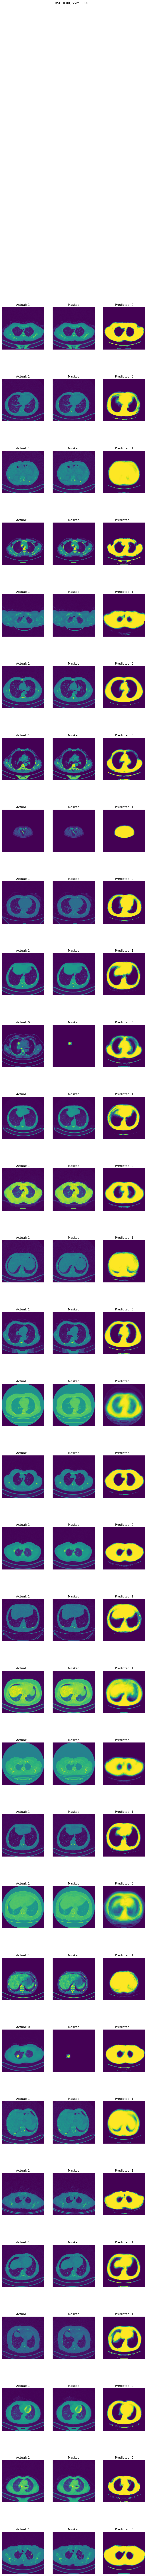

In [20]:
with torch.no_grad():
    
    inputs, classes, bounding_boxes = next(iter(dataloaders['val']))
    #reconstruction_targets = torch.tensor(list(map(mask_image, inputs, bounding_boxes)))
    #reconstruction_targets = reconstruction_targets.to(device)
    inputs = inputs.to(device)
    reconstruction_targets = inputs
    classes = classes.to(device)
    outputs, reconstructions, _ = model(inputs)
    preds = predicted_indices_from_outputs(outputs).cpu()
    _, labels = torch.max(classes.cpu(), 1)

    print("Inputs min",inputs.min().item(), "max", inputs.max().item(), "mean", inputs.mean().item(), "std", inputs.std().item())
    print("reconstruction_targets min",reconstruction_targets.min().item(), "max", reconstruction_targets.max().item(), "mean", reconstruction_targets.mean().item(), "std", reconstruction_targets.std().item())
    print("reconstructions min",reconstructions.min().item(), "max", reconstructions.max().item(), "mean", reconstructions.mean().item(), "std", reconstructions.std().item())
    print("inputs shape", inputs.size())
    print("reconstructions shape", reconstructions.size())
    compare_images([(inputs[i], reconstruction_targets[i],reconstructions[i]) for i in range(reconstructions.size(0))], preds, labels)

# Explain Model Performance
Using SHAP

# Count classes

In [23]:
numClass0 = 0
numClass1 = 0

for i, (inputs, classes, bboxes) in enumerate(dataloaders['val']):
# for i, (inputs, classes) in enumerate(dataloaders['val']):
    #_, labels = torch.max(classes.cpu(), 1)
    #batchNum1 = torch.sum(labels)
    #numClass1 += batchNum1
    #numClass0 += len(labels)-batchNum1
    print(inputs.size())
    break

print("Samples of class 0: ", numClass0)
print("Samples of class 1: ", numClass1)


torch.Size([128, 1, 128, 128])
Samples of class 0:  0
Samples of class 1:  0


# Explain Model Performance
Using SHAP

In [24]:
inputs[1:4]

tensor([[[[-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          ...,
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925]]],


        [[[-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          ...,
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927]]],


        [[[-0.4006, -0.4006, -0.4006,  ..., -0.4006, -0.4006, -0.4006],
          [-0.4006, -0.400

In [25]:
def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

transform= [
    # torchvision.transforms.Lambda(nhwc_to_nchw),
    # torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [93]:
import shap

inputs, classes, bounding_boxes = next(iter(dataloaders['train']))
inputs = transform(inputs)

def predict(img_batch):
    # print(f'Predict {img_batch.shape}')
    # print(img_batch.shape)
    img_batch = nhwc_to_nchw(torch.tensor(img_batch))
    is_single = False
    if img_batch.shape[0] == 1:
        is_single = True
        img_batch = img_batch.repeat(2,1,1,1)
    # print(is_single)
    # print(img_batch.shape)
    img_batch = img_batch.to(device)
    output, _, _ = model(img_batch)
    if is_single:
        output = output[0:1, :]
    output = softmax_output(output)
    # print(output.shape)
    return output.detach().cpu()


def softmax_output(outputs):
    classes = torch.sqrt((outputs ** 2).sum(2))
    output = torch.nn.Softmax(dim=1)(classes)
    return np.squeeze(output.detach().cpu(), -1)

In [94]:
# Based on https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

n_top_prediction = len(ds.class_names)
n_evals = 50000
# define a masker that is used to mask out partitions of the input image.
# masker_blur = shap.maskers.Image("blur(128,128)", inputs[0].shape)

# create an explainer with model and image masker
masker = shap.maskers.Image("blur(32, 32)", inputs[0].shape)
explainer = shap.Explainer(predict, masker=masker, output_names=ds.class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
input_images = inputs[:10].cpu().numpy()
# print(input_images.shape)
shap_values = explainer(input_images, max_evals=n_evals, batch_size=inputs.shape[0], outputs=shap.Explanation.argsort.flip[:2])


Partition explainer: 11it [11:23, 68.33s/it]                        


In [95]:
def write_bbox_in_matrix(data, bbox):
    width = data.shape[0]
    max = np.max(data)
    x_min, y_min, x_max, y_max = np.floor(bbox * width).numpy().astype(int)
    if x_max == width or y_max == width:
        return data
    data[x_min:x_max, y_min] = max
    data[x_max, y_min:y_max] = max
    data[x_min:x_max, y_max] = max
    data[x_min, y_min:y_max] = max
    return data

In [96]:
# Add bbox to images
shap_values.data = np.array(list(map(write_bbox_in_matrix, shap_values.data, bboxes[0:10])))

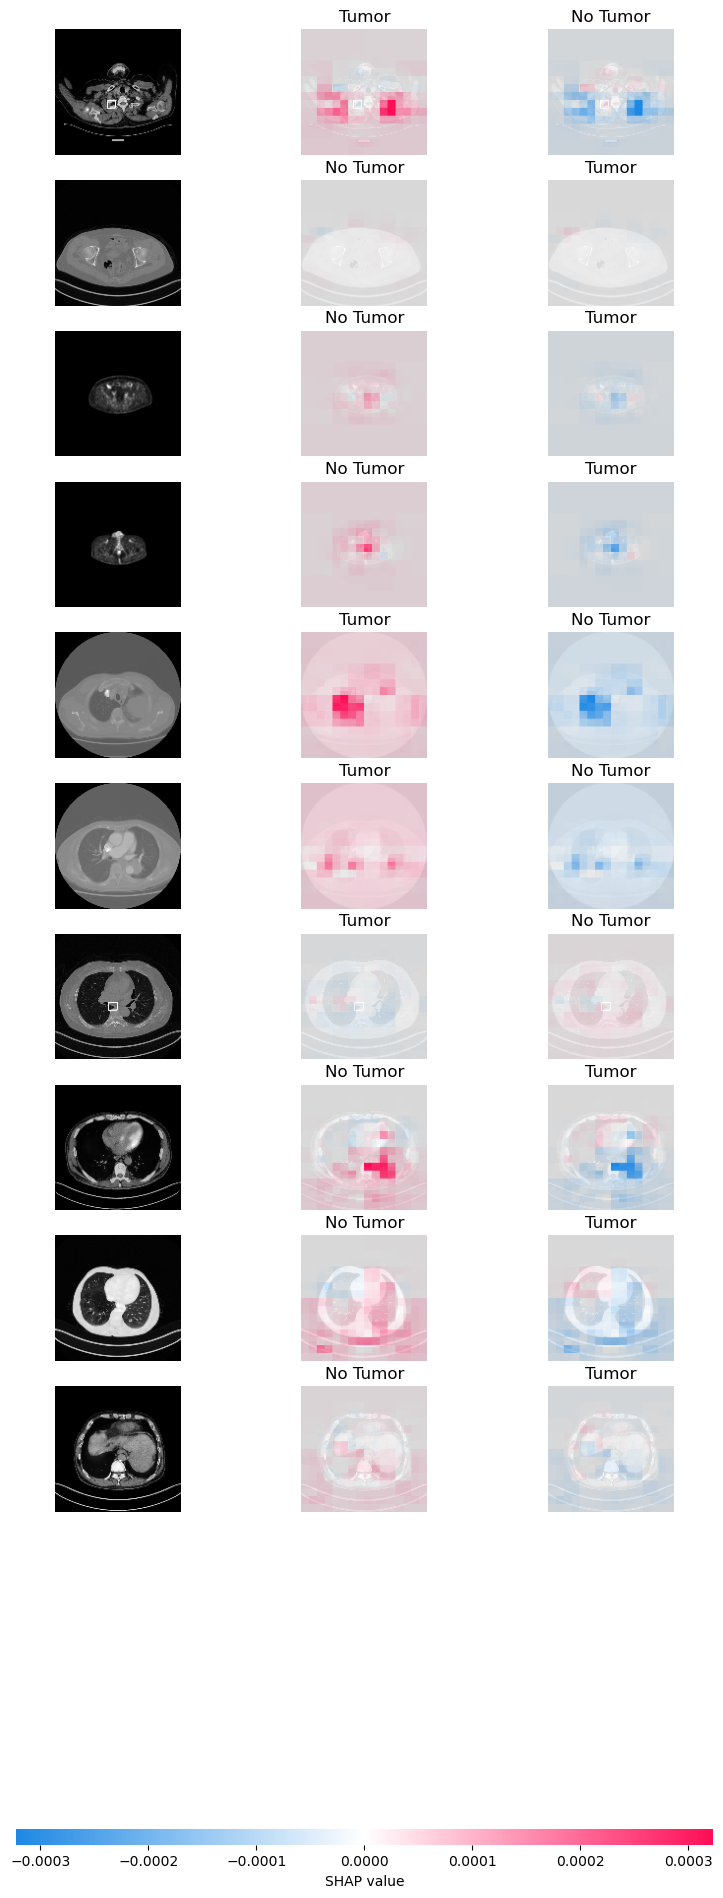

In [97]:
shap.image_plot(shap_values)